# Spotify Project

## Introduction

The project applies PyTorch, a leading deep learning framework, to the task of predicting Spotify’s popularity score (0–100) for songs based on their audio features. Our goal is to collaboratively build a neural network capable of estimating a song’s popularity using attributes such as danceability, energy, valence, tempo, and more.

By shifting from traditional machine learning approaches to a neural network–based solution, we aim to gain practical experience with an industry-standard tool while addressing a real-world regression problem. The project will involve designing, training, and evaluating multiple network architectures, with a focus on improving performance through iterative experimentation.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset


## Data Preprocessing

In [2]:
# Load the dataset
data = pd.read_csv('dataset/SpotifyFeatures.csv')

In [3]:
# Display the first few rows of the dataset
data.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


In [4]:
# Display the shape of 'data' DataFrame 
n_rows, n_cols = data.shape
print(f"The DataFrame has {n_rows} rows and {n_cols} columns") 

The DataFrame has 232725 rows and 18 columns


In [5]:
# Display informative summary of the 'data' DataFrame
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             232725 non-null  object 
 1   artist_name       232725 non-null  object 
 2   track_name        232724 non-null  object 
 3   track_id          232725 non-null  object 
 4   popularity        232725 non-null  int64  
 5   acousticness      232725 non-null  float64
 6   danceability      232725 non-null  float64
 7   duration_ms       232725 non-null  int64  
 8   energy            232725 non-null  float64
 9   instrumentalness  232725 non-null  float64
 10  key               232725 non-null  object 
 11  liveness          232725 non-null  float64
 12  loudness          232725 non-null  float64
 13  mode              232725 non-null  object 
 14  speechiness       232725 non-null  float64
 15  tempo             232725 non-null  float64
 16  time_signature    23

In [6]:
# Check for any duplicates in the dataframe
duplicates = data[data.duplicated()]
print(f"Number of duplicates: {duplicates.shape[0]}")

Number of duplicates: 0


In [7]:
# Check for missing values in 'data' DataFrame
display(data.isna().sum())

genre               0
artist_name         0
track_name          1
track_id            0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
dtype: int64

In [8]:
# Drop missing values
data = data.dropna()

# Check for missing values again
data.isna().sum()

genre               0
artist_name         0
track_name          0
track_id            0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
dtype: int64

In [9]:
# Let's remove some obvious irrelevant features
# track_id — just unique identifier
# track_name — title text
# artist_name - high cardinality and chance of data leakage

data = data.drop(columns=['track_id', 'track_name', 'artist_name'])

## EDA

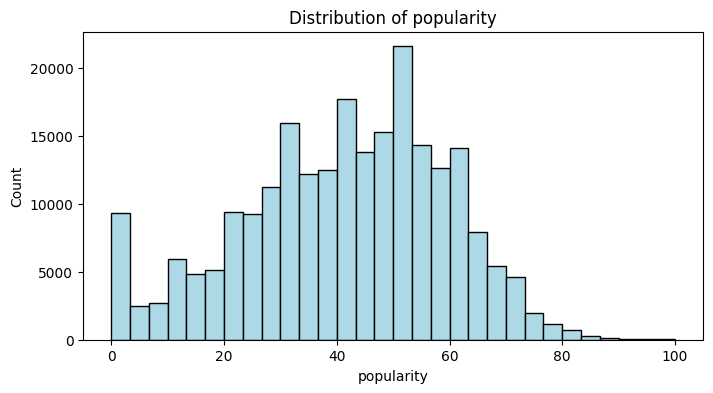

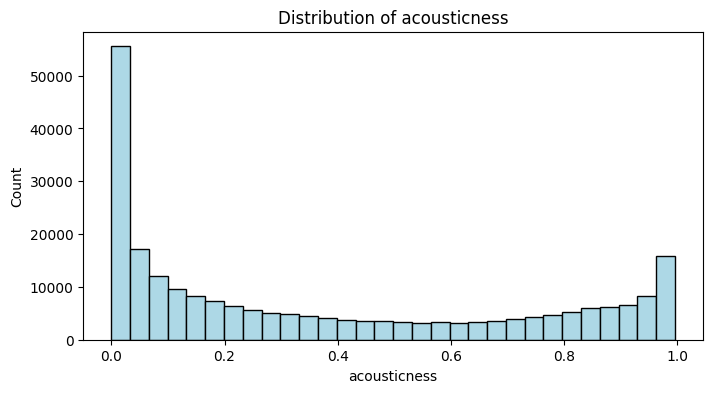

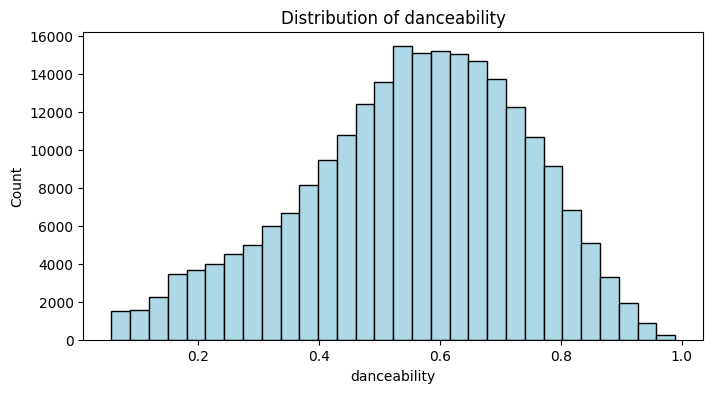

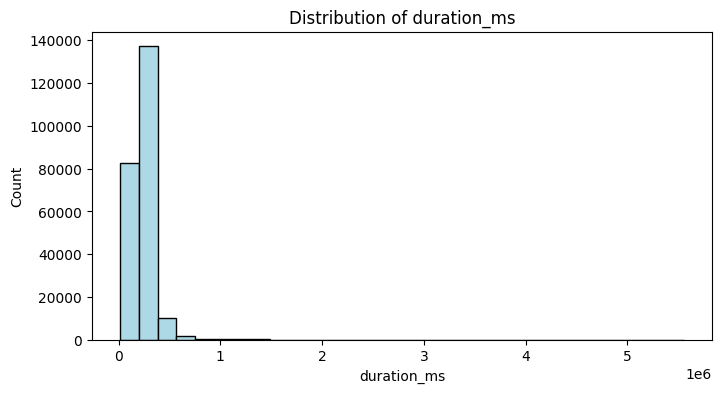

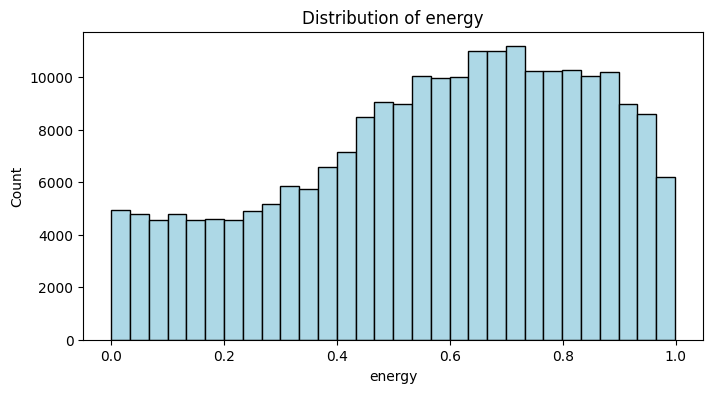

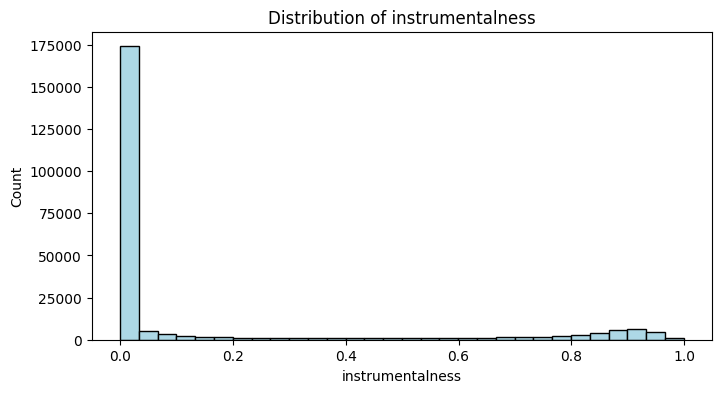

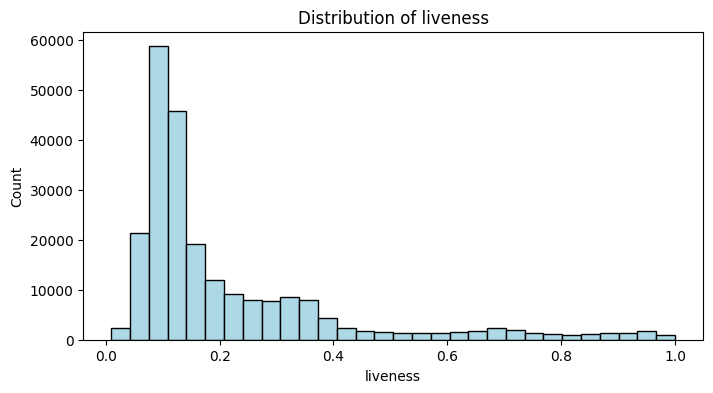

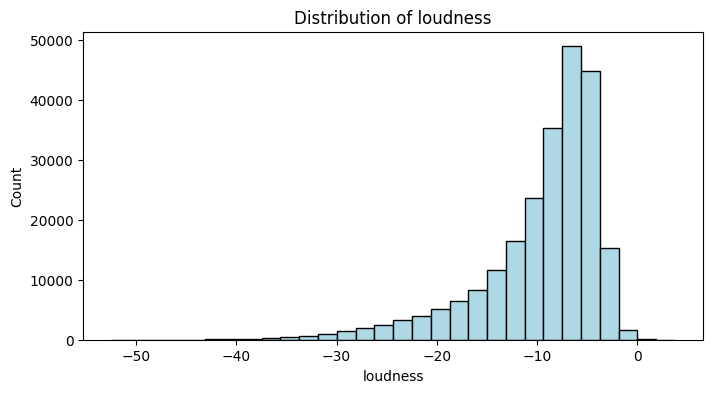

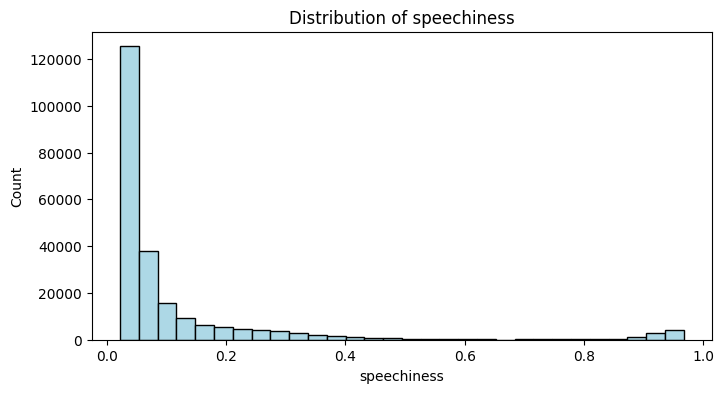

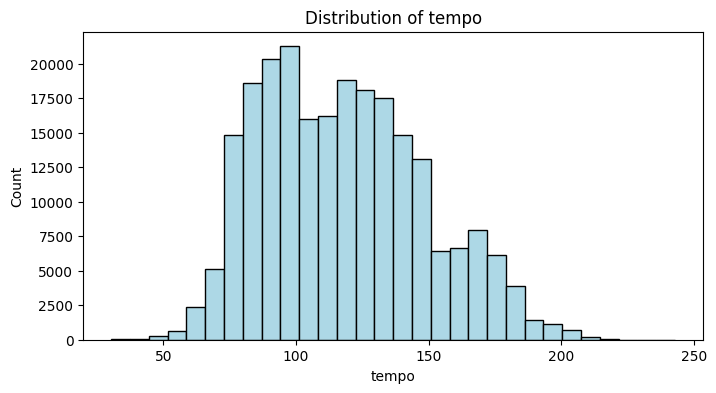

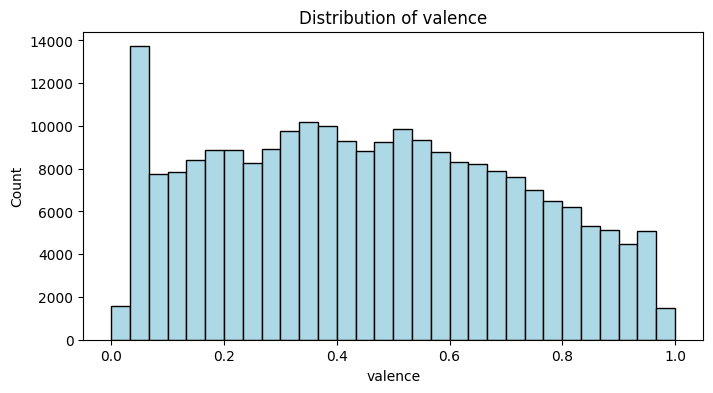

In [10]:
# Lets explore the distribution of numerical features

# Select numeric columns
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns

for one_col in numeric_cols:
    plt.figure(figsize=(8, 4))
    plt.hist(data[one_col], bins=30, color='lightblue', edgecolor='black')
    plt.title(f'Distribution of {one_col}')
    plt.xlabel(one_col)
    plt.ylabel('Count')
    plt.show()

The feature `duration_ms` distribution is too extreme. So it is better to log tranform that.

In [11]:
# log transform 
data['duration_ms_log'] = np.log1p(data['duration_ms'])

# drop original column
data = data.drop(columns=['duration_ms'])


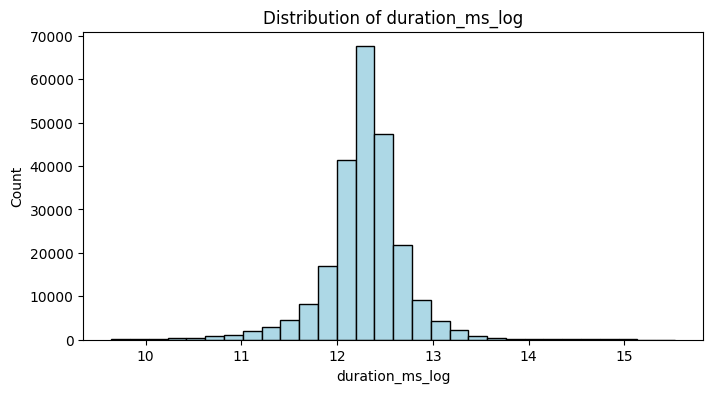

In [12]:
# Distribution after log transformation
plt.figure(figsize=(8, 4))
plt.hist(data['duration_ms_log'], bins=30, color='lightblue', edgecolor='black')
plt.title('Distribution of duration_ms_log')
plt.xlabel('duration_ms_log')
plt.ylabel('Count')
plt.show()

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 232724 entries, 0 to 232724
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             232724 non-null  object 
 1   popularity        232724 non-null  int64  
 2   acousticness      232724 non-null  float64
 3   danceability      232724 non-null  float64
 4   energy            232724 non-null  float64
 5   instrumentalness  232724 non-null  float64
 6   key               232724 non-null  object 
 7   liveness          232724 non-null  float64
 8   loudness          232724 non-null  float64
 9   mode              232724 non-null  object 
 10  speechiness       232724 non-null  float64
 11  tempo             232724 non-null  float64
 12  time_signature    232724 non-null  object 
 13  valence           232724 non-null  float64
 14  duration_ms_log   232724 non-null  float64
dtypes: float64(10), int64(1), object(4)
memory usage: 28.4+ MB


In [14]:
# Lets explore some categorical columns
# `time_signature` feature

data['time_signature'].value_counts()

time_signature
4/4    200759
3/4     24111
5/4      5238
1/4      2608
0/4         8
Name: count, dtype: int64

We can do feature engineering here: create binary column: 1 if time_signature is "4/4", otherwise 0.

In [15]:
# Create a binary column

data['time_signature'] = np.where(data['time_signature'] == '4/4', 1, 0)

# Quick check
data['time_signature'].value_counts()

time_signature
1    200759
0     31965
Name: count, dtype: int64

In [16]:
# Let's explore `mode`
data['mode'].value_counts()

mode
Major    151743
Minor     80981
Name: count, dtype: int64

We can engineer a feature to create a binary column.

In [17]:
# Create a binary column
data['mode'] = data['mode'].map({'Major': 1, 'Minor': 0})

In [18]:
# Explore `key`
data['key'].value_counts()

key
C     27583
G     26390
D     24077
C#    23201
A     22671
F     20278
B     17661
E     17390
A#    15526
F#    15222
G#    15159
D#     7566
Name: count, dtype: int64

Should we change do OHE or just remove this column? Need to discuss....

In [19]:
# Explore `genre`
data['genre'].value_counts()

genre
Comedy              9681
Soundtrack          9646
Indie               9543
Jazz                9441
Pop                 9386
Electronic          9377
Children’s Music    9353
Folk                9299
Hip-Hop             9295
Rock                9272
Alternative         9263
Classical           9256
Rap                 9232
World               9095
Soul                9089
Blues               9023
R&B                 8992
Anime               8936
Reggaeton           8927
Ska                 8874
Reggae              8771
Dance               8701
Country             8664
Opera               8280
Movie               7806
Children's Music    5403
A Capella            119
Name: count, dtype: int64

This is a bit tricky. This feature seems important to me. But at the same time, if we do OHE, we will be increasing so many features. Not sure what to do. Discard or keep it? Need to discuss on that......

In [20]:
data['genre'] = data['genre'].replace({
    "Children’s Music": "Children's Music",
})

print(data['genre'].value_counts())

genre
Children's Music    14756
Comedy               9681
Soundtrack           9646
Indie                9543
Jazz                 9441
Pop                  9386
Electronic           9377
Folk                 9299
Hip-Hop              9295
Rock                 9272
Alternative          9263
Classical            9256
Rap                  9232
World                9095
Soul                 9089
Blues                9023
R&B                  8992
Anime                8936
Reggaeton            8927
Ska                  8874
Reggae               8771
Dance                8701
Country              8664
Opera                8280
Movie                7806
A Capella             119
Name: count, dtype: int64


In [21]:
# High-energy danceable songs tend to be more popular in reels and tiktok. Let's do feature engineering
data['energy_danceability'] = data['energy'] * data['danceability']

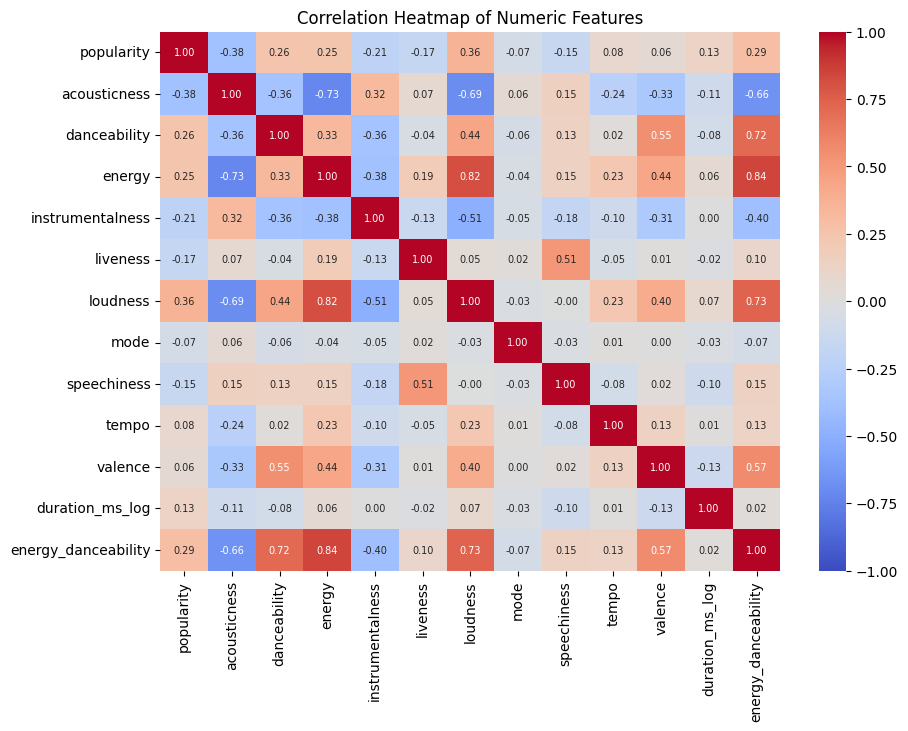

In [22]:
# Create a heat map to see if there is multicollinearity.

# Select numeric columns
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns

# Correlation matrix
corr_matrix = data[numeric_cols].corr()

# Plot heatmap 
plt.figure(figsize=(10, 7))
sns.heatmap(
    corr_matrix, 
    annot=True,          
    fmt='.2f',           
    cmap='coolwarm',
    annot_kws={'size': 7},     
    vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

No multicollinearity.

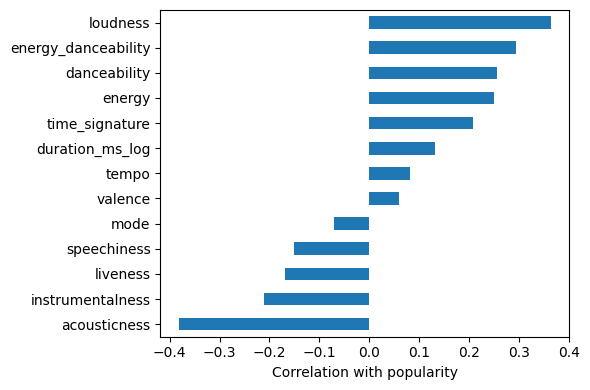

In [23]:
# Let's explore how target is correlated to numeric features

num_features = data.select_dtypes(include='number').columns.drop('popularity')
corr = data[num_features].corrwith(data['popularity']).sort_values()

# Plot the correlation with popularity
plt.figure(figsize=(6, 4))
corr.plot.barh()
plt.xlabel('Correlation with popularity')
plt.tight_layout()
plt.show()


In [24]:
row = data.iloc[0] 

row_norm = row.copy()

for col in ['loudness', 'tempo']:
    row_norm[col] = (row[col] - data[col].min()) / (data[col].max() - data[col].min())

In [25]:
# Creating feature names list
features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 
            'liveness', 'loudness', 'speechiness', 'tempo', 'valence']

target = ['popularity']

In [26]:
# Prepare data
plot_data = pd.DataFrame({
    'feature': features,
    'value': [row_norm[feat] for feat in features]
})

# Plot interactive radar chart
fig = px.line_polar(plot_data, r='value', theta='feature', line_close=True,
                    title=f"Audio Feature Profile - {row['genre']}")
fig.update_traces(fill='toself')
fig.show()

## Model 

In [27]:
# Prepare data for model training
X = data[features].values
y = data[target].values

In [28]:
# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [29]:
# First split: train (60%) vs temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=75)

# Second split: validation (20%) vs test (20%) from temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=75)

# Display the shapes of the splits
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}, Validation shape: {X_val.shape}")

Train shape: (139634, 9), Test shape: (46545, 9), Validation shape: (46545, 9)


In [30]:
# Convert features and target to tensors and move to device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define model
n_features = X_train.shape[1]

model = nn.Sequential(
    nn.Linear(n_features, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, 1)
)

# Loss and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

# Early stopping parameters
num_epochs = 50
best_val_rmse = float("inf")
patience = 5
counter = 0

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss_sum = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = loss_fn(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss_sum += loss.item() * batch_X.size(0)
    
    train_rmse = math.sqrt(train_loss_sum / len(train_loader.dataset))
    
    # Validation
    model.eval()
    val_loss_sum = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = loss_fn(outputs, batch_y)
            val_loss_sum += loss.item() * batch_X.size(0)
    
    val_rmse = math.sqrt(val_loss_sum / len(val_loader.dataset))
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train RMSE: {train_rmse:.4f}, Validation RMSE: {val_rmse:.4f}")
    
    # Early stopping check
    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        counter = 0
        # Save best model weights
        best_model_wts = model.state_dict()
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

# Load best model
model.load_state_dict(best_model_wts)

# Test evaluation
model.eval()
test_loss_sum = 0.0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        loss = loss_fn(outputs, batch_y)
        test_loss_sum += loss.item() * batch_X.size(0)

test_rmse = math.sqrt(test_loss_sum / len(test_loader.dataset))
print(f"Test RMSE: {test_rmse:.4f}")


Epoch [1/50], Train RMSE: 18.0657, Validation RMSE: 15.1819
Epoch [2/50], Train RMSE: 15.7950, Validation RMSE: 15.1037
Epoch [3/50], Train RMSE: 15.6813, Validation RMSE: 15.0620
Epoch [4/50], Train RMSE: 15.6040, Validation RMSE: 15.0642
Epoch [5/50], Train RMSE: 15.5605, Validation RMSE: 15.1236
Epoch [6/50], Train RMSE: 15.5194, Validation RMSE: 15.0197
Epoch [7/50], Train RMSE: 15.4988, Validation RMSE: 15.0035
Epoch [8/50], Train RMSE: 15.4680, Validation RMSE: 14.9934
Epoch [9/50], Train RMSE: 15.4360, Validation RMSE: 15.0039
Epoch [10/50], Train RMSE: 15.4224, Validation RMSE: 14.9766
Epoch [11/50], Train RMSE: 15.4057, Validation RMSE: 15.0027
Epoch [12/50], Train RMSE: 15.3972, Validation RMSE: 15.0084
Epoch [13/50], Train RMSE: 15.3683, Validation RMSE: 14.9889
Epoch [14/50], Train RMSE: 15.3554, Validation RMSE: 14.9752
Epoch [15/50], Train RMSE: 15.3382, Validation RMSE: 14.9642
Epoch [16/50], Train RMSE: 15.3312, Validation RMSE: 15.0094
Epoch [17/50], Train RMSE: 15.327